<a href="https://colab.research.google.com/github/bmoretz/MSDS-MachineLearning/blob/master/Shared/Team_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workspace Initialization

## Libraries & Standard Setup

In [63]:
!pip install jupyterthemes

In [64]:
!pip install Pillow

In [0]:
!pip install -U -q PyDrive

In [0]:
%matplotlib inline

import os
import io

# Core
import pandas as pd
import numpy as np

# Visuals
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# jt themes
from jupyterthemes import jtplot

# Display Images
from PIL import Image, ImageFilter

# IPython display
from IPython.display import display

# Loading Zip Files
import zipfile

In [0]:
import tensorflow as tf
import time

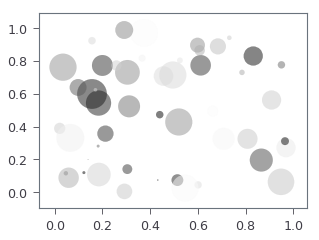

In [68]:
# Test Theme
!jt -t grade3 -f fira -fs 115
jtplot.style(theme='oceans16')

# set "context" (paper, notebook, talk, poster)
# scale font-size of ticklabels, legend, etc.
# remove spines from x and y axes and make grid dashed
jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')

# turn on X- and Y-axis tick marks (default=False)
# turn off the axis grid lines (default=True)
# and set the default figure size
jtplot.style(ticks=True, grid=False, figsize=(6, 4.5))

N = 50
x = np.random.rand(N)
y = np.random.rand(N)
colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2

plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.show()

Looks good. Let's roll.

### Gloabls

In [0]:
RANDOM_SEED = 42

IMG_WIDTH = 64
IMG_HEIGHT = 64

### Utility

Function to make output stable across runs.

In [0]:
def reset_graph(seed= RANDOM_SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# Project Dataset

## Cats Vs. Dogs Training Data

Load the cats vs. dogs dataset from mounted drive.

In [71]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
X_train = []
Y_train = []

with zipfile.ZipFile('/content/drive/My Drive/datasets/cats_vs_dogs/train.zip', 'r') as z:
  for fn in z.namelist():
    if not os.path.isdir(fn) and fn.endswith("jpg"):
      img_bytes = io.BytesIO(z.read(fn))
      X_train.append(img_bytes)
      
      if 'cat' in fn: 
        Y_train.append('Cat')
      else:
        Y_train.append('Dog')

## Data Set Exploration

### Graphical Utility

Peek an image and it's label from the training data.

In [0]:
def peek_img( index ):
  img = Image.open(X_train[index])
  imshow(img)
  plt.title(Y_train[index])
  plt.show()

Show an image in grey scale format.

In [0]:
def show_grayscale_image(image):
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

## Data Exploration

Let's explore some of the training data. We'll start with the first image in the set.

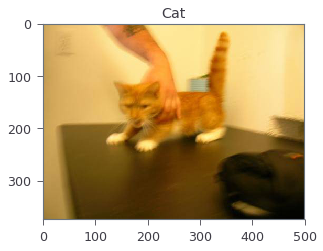

In [75]:
peek_img(0)

Now let's find a dog and make sure it's labeled correctly.

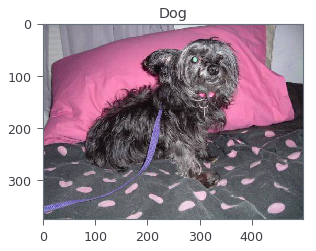

In [76]:
first_dog = Y_train.index('Dog')
peek_img(first_dog)

# Model

Reset model to default state.

In [0]:
reset_graph()

## Model Data Preperation

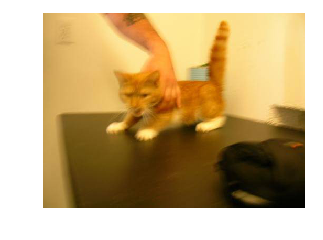

In [78]:
index = 0

img = Image.open(X_train[index])
img_array = np.array(img)
show_grayscale_image(img_array)